## 필수 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## 데이터 불러오기 및 간단하게 살펴보기

In [2]:
PATH = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')
submission = pd.read_csv(PATH + 'sampleSubmission.csv')

In [3]:
# train과 test columns이 다른건 의외네
print(train.shape, test.shape)

(10886, 12) (6493, 9)


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
'''
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday (0이면 공휴일 아님, 1이면 공휴일)
workingday - whether the day is neither a weekend nor holiday (0이면 근무일 아님, 1이면 근무일) - 주말과 공휴일이 아니면 근무일로 판단
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius (체감온도)
humidity - relative humidity
windspeed - wind speed

casual - number of non-registered user rentals initiated (등록되지 않은 사용자 수)
registered - number of registered user rentals initiated (등록된 사용자 수)
count - number of total rentals (자전거 대여 수량)

즉, season~registered까지는 예측에 사용할 수 있는 피처고, count는 예측해야할 타깃값이다
근데 실제로는 casual, registered를 사용할 필요는 없을듯.. 어차피 test에 없는 columns이라서..
'''
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [6]:
# test에서는 casual, registered 가 빠진것을 알 수 있다. 따라서 학습시에도 저 두개는 빼야겠네
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
# test를 통해 예측한 결과(count)를 여기다가 업데이트 시킨후 제출하면 된다
# datatime은 결국 ID 값이라고 보면 될 듯..!
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
# 결측치는 없음. 결측치가 있다면 적절한 처리해줘야 함. 없애던가 대체하던가
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [9]:
# 마찬가지로 결측치 없음
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


## 데이터 분석과 시각화(EDA)

### datetime 피처 엔지니어링
- datatime 형태는 시각화하기 어려운 구조. 
- object 형은 판다스에서는 문자열 타입이라고 보면 됨.
- 이를 세부적으로 보려면 구성요소별(월, 일, 시간, 분, 초)로 나눌 필요가 있음

In [10]:
print(train['datetime'][100])
print(train['datetime'][100].split())
print(train['datetime'][100].split()[0])
print(train['datetime'][100].split()[1])

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


In [11]:
print(train['datetime'][100].split(' ')[1].split(':'))
print(train['datetime'][100].split(' ')[1].split(':')[0]) # 시간
print(train['datetime'][100].split(' ')[1].split(':')[1]) # 분
print(train['datetime'][100].split(' ')[1].split(':')[2]) # 초

['09', '00', '00']
09
00
00


In [12]:
# 연도, 월, 일, 시, 분, 초 피처를 차례대로 생성
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2])

train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2])

In [13]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,01,01,04,00,00


In [14]:
# 요일 피처도 생성해보자 (날짜 -> 요일 추출)
from datetime import datetime
import calendar

print(train['datetime'][100].split()[0])
print(datetime.strptime(train['datetime'][100].split()[0], '%Y-%m-%d')) # datetime 타입으로 변경

# 정수로 요일 반환
print(datetime.strptime(train['datetime'][100].split()[0], '%Y-%m-%d').weekday())
# 문자열로 요일 반환
print(calendar.day_name[datetime.strptime(train['datetime'][100].split()[0], '%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


In [15]:
train['weekday'] = train['datetime'].apply(
    lambda dateStr: calendar.day_name[datetime.strptime(dateStr.split()[0], '%Y-%m-%d').weekday()]
)

In [16]:
# season과 weather 피처를 시각화 의미가 잘 드러나도록 숫자를 문자열로 변경
train['season'] = train['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
train['weather'] = train['weather'].map({1: 'Clear', 2: 'Mist, Few clouds', 
                      3: 'Light Snow, Rain, Thunderstorm', 4: 'Heavy Rain, Thunderstorm, Snow, Fog'})

### 데이터 시각화 - displot(분포도)

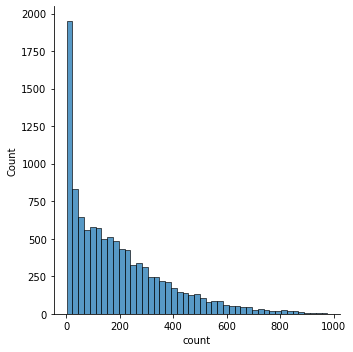

In [17]:
# 타깃값 count 분포는 0 근처에 몰려 있는 것을 알 수 있다 
sns.displot(train['count'])

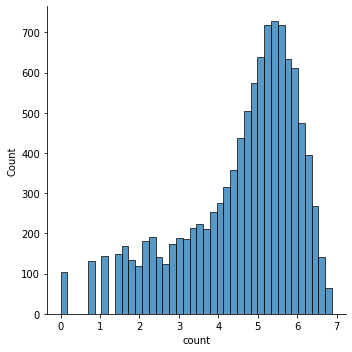

In [18]:
# 로그변환을 통해 정규분포에 가깝게 만들어주는 것이 회귀 분석시 좋음
sns.displot(np.log(train['count']))

### 데이터 시각화 - barplot

In [19]:
train.groupby('year')['count'].mean()

year
2011    144.223349
2012    238.560944
Name: count, dtype: float64

[Text(0.5, 1.0, 'Rental amounts by second')]

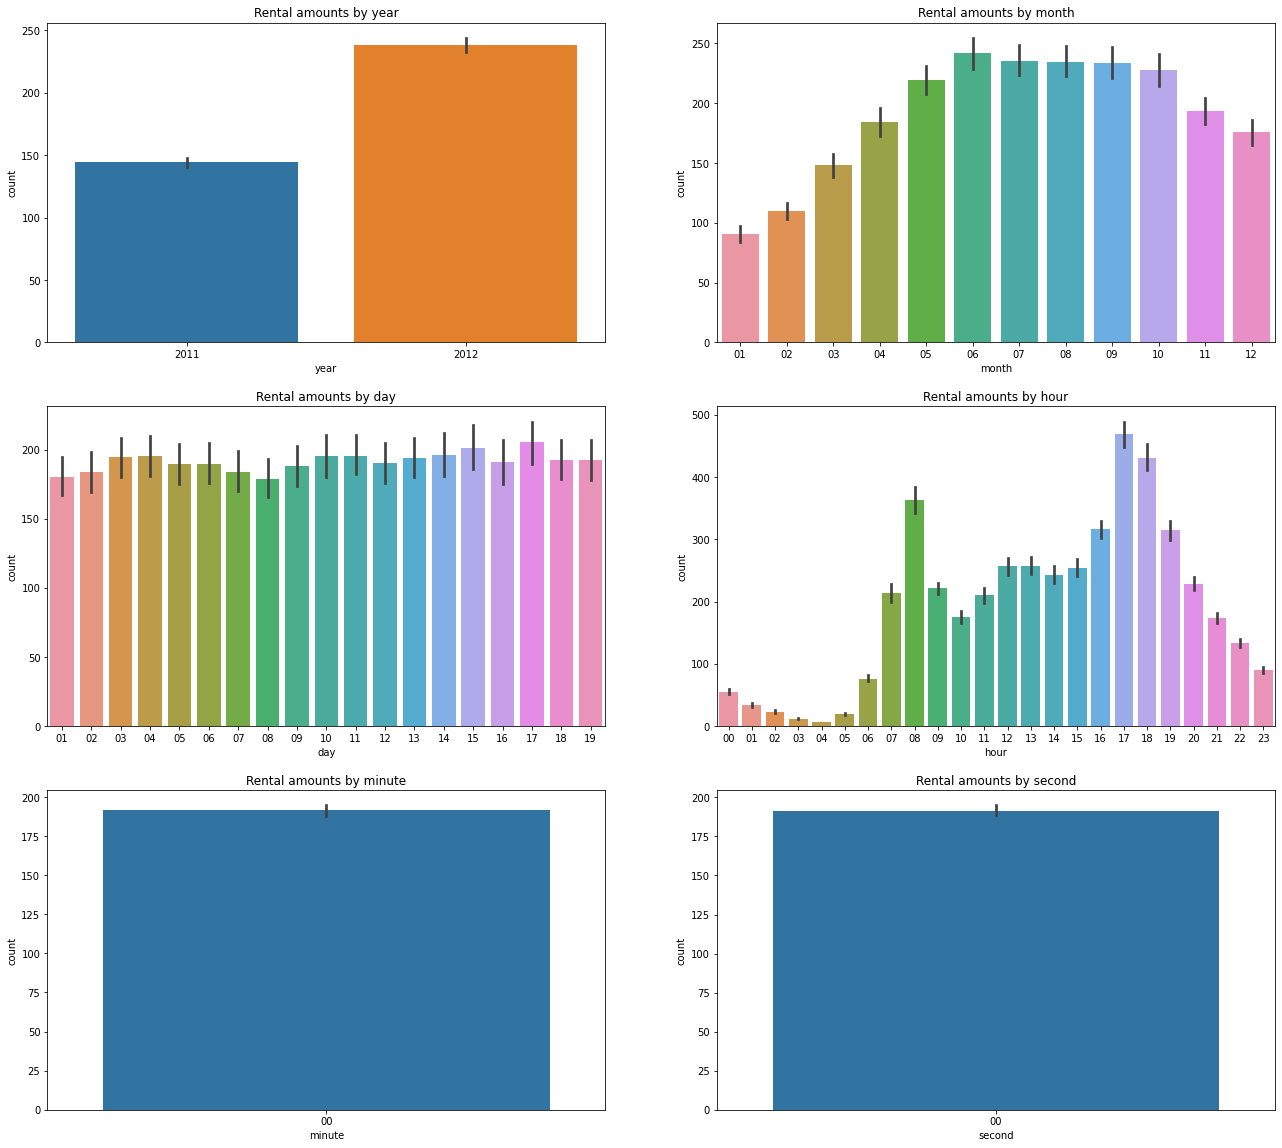

In [20]:
# 연도, 월, 일, 시, 분, 초별 평균 대여 수량 barplot
figure, axes = plt.subplots(figsize=(22, 20), nrows=3, ncols=2)
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0]) # 2012가 더 수요가 높아졌음
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1]) # 겨울보다 여름이 역시 자전거 수요가 많음
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0]) # day를 보면 1~19까지밖에 없음. 나머지 일자는 테스트에 있음. 결국 day 피처는 버리는걸로
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1]) # 출근과 퇴근시간이 제일 수요가 많음
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0]) # 0으로 통일됨, 필요없음
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1]) # 0으로 통일됨, 필요없음

axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

### 데이터 시각화 - boxplot(박스플롯)

<AxesSubplot:xlabel='workingday', ylabel='count'>

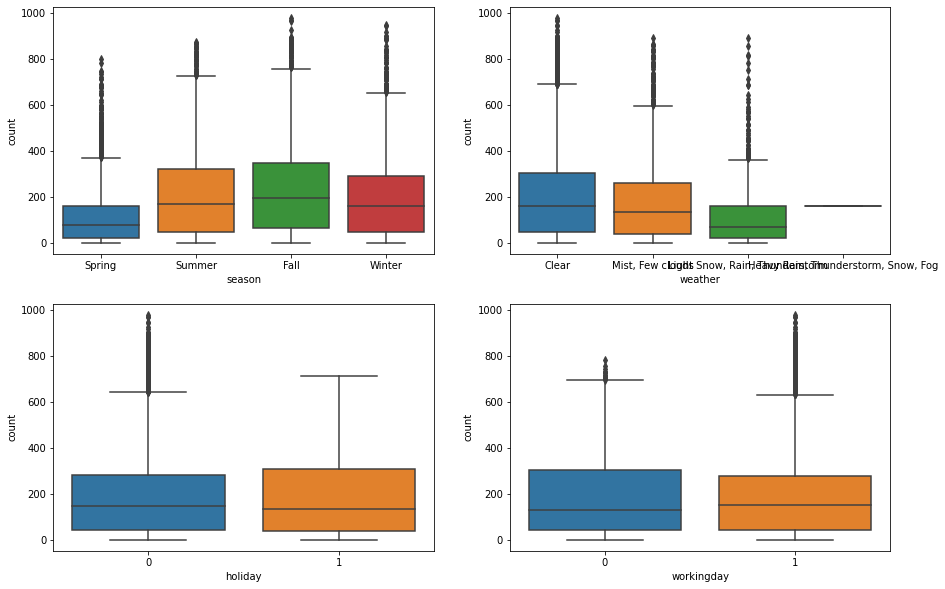

In [21]:
# 계절, 날씨, 공휴일, 근무일별 대여수량을 박스플롯으로 출력
figure, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)

sns.boxplot(x='season', y='count', data=train, ax=axes[0, 0]) # 봄에 가장 적고(왜지..미국이라 그런가), 가을에 가장 많다
sns.boxplot(x='weather', y='count', data=train, ax=axes[0, 1]) # 날씨가 좋을때가 당연히 가장 많음
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1, 0]) # 공휴일일때와 아닐때 모두 별반 차이는 없다, 다만 공휴일이 아닐때 이상치(outlier)가 많다
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1]) # 근무일일때 이상치가 역시 많다 

### 데이터 시각화 - pointplot(포인트플롯)

<AxesSubplot:xlabel='hour', ylabel='count'>

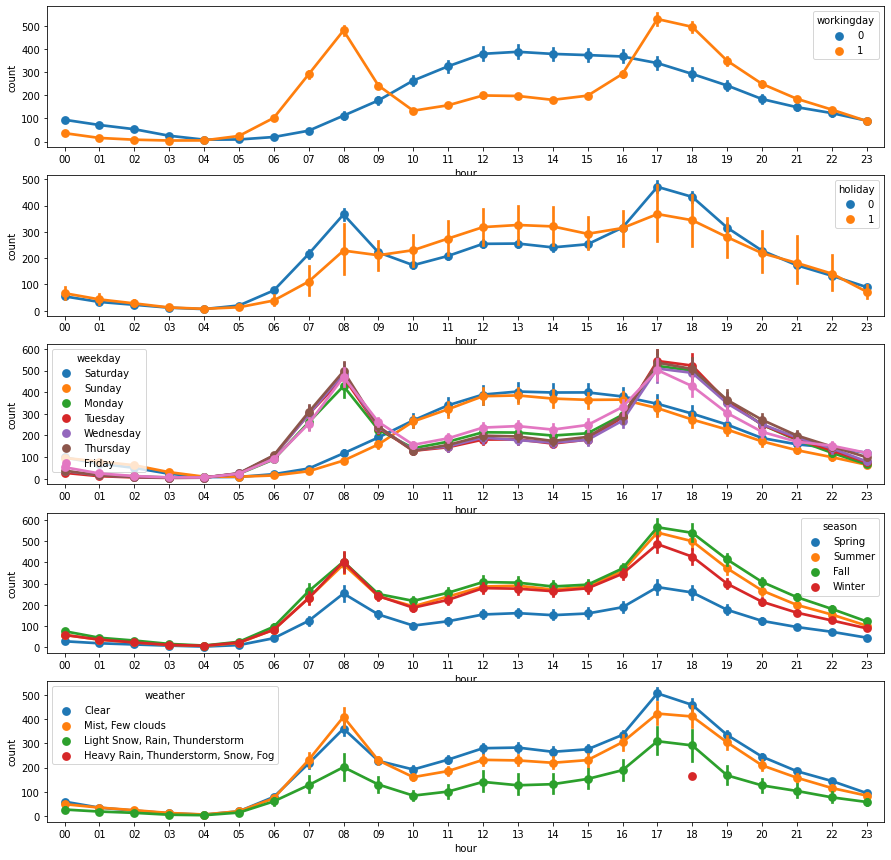

In [22]:
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여수량을 포인트플롯으로 출력
figure, axes = plt.subplots(figsize=(15, 15), nrows=5)

# 일하는 날에는 출퇴근 이용률이 높다. 반면 휴일은 낮시간이 가장 많다
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0]) 
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4]) # weather이 4인건 그냥 없애는걸로..

### 데이터 시각화 - regplot(산점도 그래프)

<AxesSubplot:xlabel='humidity', ylabel='count'>

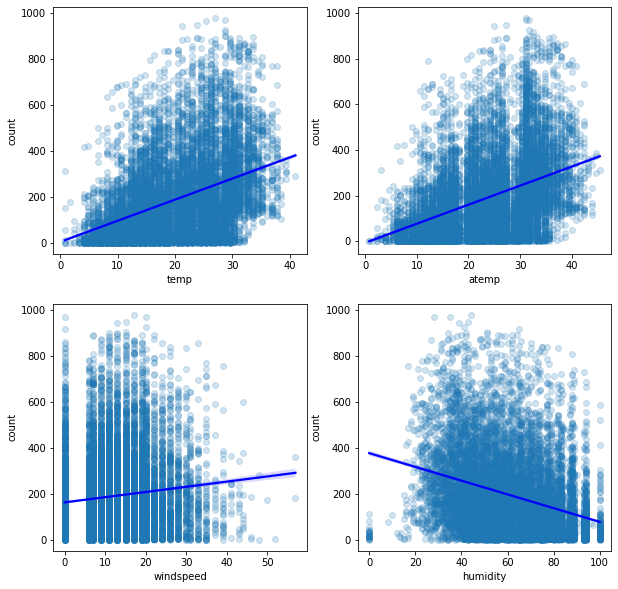

In [23]:
# 온도, 체감온도, 풍속, 습도별(수치형 데이터) 대여 수량을 산점도 그래프로 확인
figure, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

# 온도는 높을수록 수요가 증가한다. 아무래도 추운것보다는...
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0], scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1], scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})

# 의외로 풍속이 강할수록 증가하는데, 이건 풍속이 0인 데이터가 많아서 그래... 실제 0이 아니라 관측치가 없거나 오류로 인해 0이 됐을 가능성
# 따라서 windspeed를 제거하거나 결측치를 다른값으로 대체하던가 해야 함. 여기서는 너무 많아서 제거
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0], scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})

# 습도는 낮을수록 수요가 증가한다. 역시 찝찝한거보다는..
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1], scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})

### 데이터 시각화 - 히트맵

In [24]:
# temp, atemp, humidity, windspeed, count 상관관계 파악
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


<AxesSubplot:>

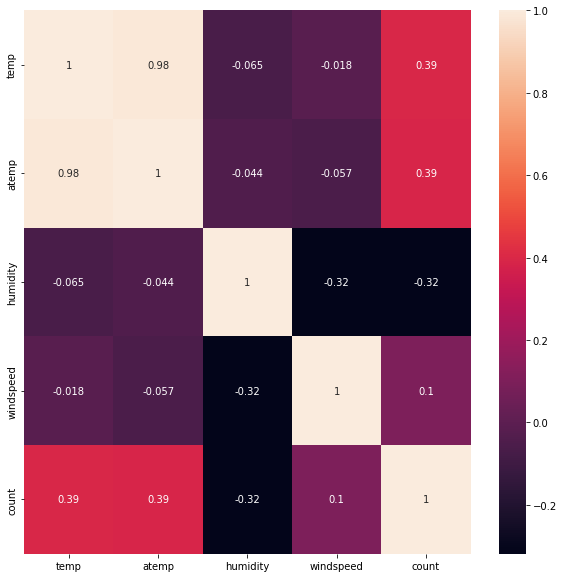

In [25]:
figure, axes = plt.subplots(figsize=(10, 10))

# 타깃값인 count와의 상관관계가 중요 - temp, atemp와는 양의 상관관계, humidity와는 음의 상관관계를 보여줌. windspeed는 미미함...(버려)
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
sns.heatmap(corrMat, annot=True)